In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import os
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Using TensorFlow backend.


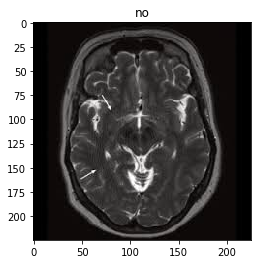

In [2]:
# This are the files where the images are stored 
TRAIN_VALID_PATH = '/Users/prathiklolla/Documents/Brain-Tumor-Detection/train+validation'
TEST_PATH = '/Users/prathiklolla/Documents/Brain-Tumor-Detection/test'

CATEGORIES = ['no', 'yes']
for category in CATEGORIES:
    path = TEST_PATH + '/' + category
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        plt.imshow(img_array, cmap = 'gray')
        plt.title(category)
        plt.show()
        break
    break

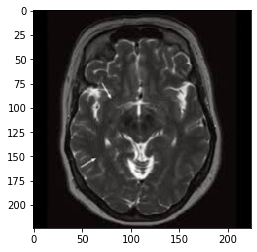

In [3]:
# Resize the images so it will be easier to feed into our model
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [4]:
# Creating our train and test datasets
test_data = []
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = TRAIN_VALID_PATH + '/' + category
        label = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), cv2.IMREAD_COLOR)
                train_data.append([new_array, label])
            except Exception as e:
                pass
            
def create_test_data():
    for category in CATEGORIES:
        path = TEST_PATH + '/' + category
        label = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), cv2.IMREAD_COLOR)
                test_data.append([new_array, label])
            except Exception as e:
                pass

create_train_data()
create_test_data() 

random.shuffle(train_data)
random.shuffle(test_data)

In [5]:
# Seperating the inputs and targets
train_inputs = []
train_targets = []

test_inputs = []
test_targets = []

for features, labels in train_data:
    train_inputs.append(features)
    train_targets.append(labels)

for features, labels in test_data:
    test_inputs.append(features)
    test_targets.append(labels)
    
train_inputs = np.array(train_inputs).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_inputs = np.array(test_inputs).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Saving the arrays in an .npz file
np.savez('train_data', inputs = train_inputs, targets = train_targets)
np.savez('test_data', inputs = test_inputs, targets = test_targets)

In [6]:
# Opening the files
npz = np.load('train_data.npz')

train_inputs = npz['inputs']
train_inputs = train_inputs/255.

train_targets = npz['targets']

npz = np.load('test_data.npz')

test_inputs = npz['inputs']
test_inputs = test_inputs/255.

test_targets = npz['targets']

## MobileNetV2

In [7]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE,3)

# Creating the base of our model using MobileNetV2
base_model_v2 = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

In [8]:
# We are freezing the base of our model, because we don't want to train all of its parameters, just the ones we need for our problem
base_model_v2.trainable = False
base_model_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
model_mnv2 = tf.keras.models.Sequential()

model_mnv2.add(base_model_v2)
model_mnv2.add(tf.keras.layers.GlobalAveragePooling2D())
model_mnv2.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [10]:
model_mnv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# To prevent overfitting we will implement an early stopping callback 
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5)

EPOCHS = 100

model_mnv2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history_mnv2 = model_mnv2.fit(
    train_inputs,
    train_targets,
    epochs = EPOCHS,
    batch_size = 64,
    validation_split = 0.05,

    verbose = 2)

Epoch 1/100
4/4 - 8s - loss: 0.7713 - accuracy: 0.4861 - val_loss: 0.6952 - val_accuracy: 0.5833
Epoch 2/100
4/4 - 4s - loss: 0.7096 - accuracy: 0.6111 - val_loss: 0.6616 - val_accuracy: 0.5833
Epoch 3/100
4/4 - 5s - loss: 0.6369 - accuracy: 0.6296 - val_loss: 0.5631 - val_accuracy: 0.6667
Epoch 4/100
4/4 - 5s - loss: 0.5646 - accuracy: 0.6667 - val_loss: 0.5142 - val_accuracy: 0.9167
Epoch 5/100
4/4 - 5s - loss: 0.5181 - accuracy: 0.7500 - val_loss: 0.4784 - val_accuracy: 0.9167
Epoch 6/100
4/4 - 5s - loss: 0.4772 - accuracy: 0.8426 - val_loss: 0.4360 - val_accuracy: 0.9167
Epoch 7/100
4/4 - 5s - loss: 0.4335 - accuracy: 0.8472 - val_loss: 0.3984 - val_accuracy: 1.0000
Epoch 8/100
4/4 - 4s - loss: 0.4089 - accuracy: 0.8426 - val_loss: 0.3725 - val_accuracy: 0.9167
Epoch 9/100
4/4 - 4s - loss: 0.3886 - accuracy: 0.8426 - val_loss: 0.3494 - val_accuracy: 1.0000
Epoch 10/100
4/4 - 4s - loss: 0.3652 - accuracy: 0.8843 - val_loss: 0.3402 - val_accuracy: 0.9167
Epoch 11/100
4/4 - 4s - loss:

Epoch 85/100
4/4 - 4s - loss: 0.0859 - accuracy: 0.9907 - val_loss: 0.1640 - val_accuracy: 0.9167
Epoch 86/100
4/4 - 5s - loss: 0.0849 - accuracy: 0.9954 - val_loss: 0.1612 - val_accuracy: 0.9167
Epoch 87/100
4/4 - 5s - loss: 0.0840 - accuracy: 0.9954 - val_loss: 0.1633 - val_accuracy: 0.8333
Epoch 88/100
4/4 - 5s - loss: 0.0828 - accuracy: 1.0000 - val_loss: 0.1709 - val_accuracy: 0.8333
Epoch 89/100
4/4 - 5s - loss: 0.0820 - accuracy: 1.0000 - val_loss: 0.1704 - val_accuracy: 0.8333
Epoch 90/100
4/4 - 4s - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.1679 - val_accuracy: 0.8333
Epoch 91/100
4/4 - 5s - loss: 0.0800 - accuracy: 1.0000 - val_loss: 0.1656 - val_accuracy: 0.8333
Epoch 92/100
4/4 - 5s - loss: 0.0790 - accuracy: 1.0000 - val_loss: 0.1661 - val_accuracy: 0.8333
Epoch 93/100
4/4 - 5s - loss: 0.0781 - accuracy: 1.0000 - val_loss: 0.1657 - val_accuracy: 0.8333
Epoch 94/100
4/4 - 4s - loss: 0.0774 - accuracy: 1.0000 - val_loss: 0.1642 - val_accuracy: 0.8333
Epoch 95/100
4/4 - 4

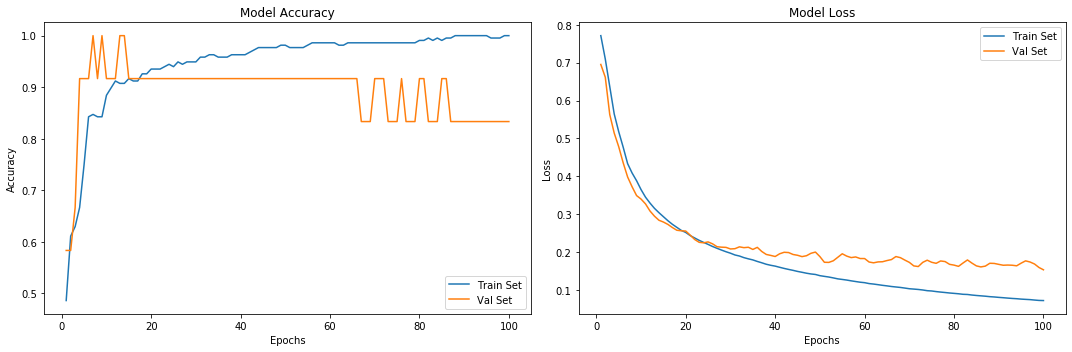

In [12]:
# plot model performance
acc = history_mnv2.history['accuracy']
val_acc = history_mnv2.history['val_accuracy']
loss = history_mnv2.history['loss']
val_loss = history_mnv2.history['val_loss']
epochs_range = range(1, len(history_mnv2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [13]:
# Using the model to classify the test data
test_pred_mnv2 = model_mnv2.predict(test_inputs)
test_pred_mnv2 = [1 if x > 0.5 else 0 for x in test_pred_mnv2]

# shows the precision, recall and f1-scores for each class
print(classification_report(test_targets, test_pred_mnv2))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



In [14]:
model_mnv2.save('/Users/prathiklolla/Documents/Brain-Tumor-Detection/')

INFO:tensorflow:Assets written to: /Users/prathiklolla/Documents/Brain-Tumor-Detection/assets


In [29]:
img_array = cv2.imread("/Users/prathiklolla/Documents/Brain-Tumor-Detection/test/yes/Y1.jpg", cv2.IMREAD_COLOR)
new_array = cv2.resize(img_array, (224, 224))
new_array = np.array(new_array).reshape(-1, 224, 224, 3)

prediction = model_mnv2.predict(new_array) # this will be an array with one element
prediction

array([[0.9792297]], dtype=float32)

In [16]:
model_mnv2.predict(test_inputs)

array([[0.35171562],
       [0.0539659 ],
       [0.09231827],
       [0.49265903],
       [0.6026591 ],
       [0.11084285],
       [0.03609237],
       [0.98412204],
       [0.35484225],
       [0.11700371],
       [0.9277804 ],
       [0.02038959],
       [0.0848709 ],
       [0.87510407],
       [0.9733914 ],
       [0.02403423],
       [0.9916391 ],
       [0.99518746],
       [0.7872962 ],
       [0.9945309 ],
       [0.03609237],
       [0.8897513 ],
       [0.13091418],
       [0.9999696 ],
       [0.46182021]], dtype=float32)